In [50]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import numpy as np

use_cuda = torch.cuda.is_available()

In [51]:
import torchvision
import torchvision.transforms as transforms
import cv2

In [52]:
transform = transforms.Compose(
    [transforms.CenterCrop((64,64)),
     transforms.ToTensor(),])
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

lsun = torchvision.datasets.ImageFolder('/Users/soobin/Deepest/GANs', transform=transform)

In [53]:
dataloader = torch.utils.data.DataLoader(lsun, batch_size=16, shuffle=True, num_workers=2)

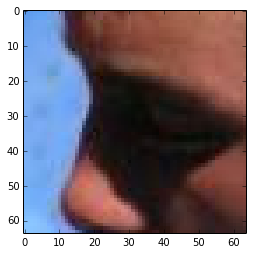

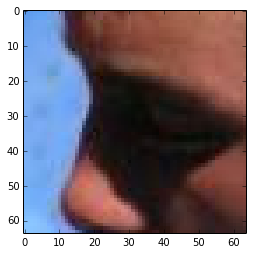

In [80]:
data,_ = iter(dataloader).next()

to_pil = torchvision.transforms.ToPILImage()
to_pil(data[0])

import matplotlib
from matplotlib import pyplot as plt
from IPython import display
# from pylab import plt
%matplotlib inline

def show(img):

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
show(data[9])

In [82]:

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 16 * 16 * 128)
        self.conv1 = nn.Conv2d(128, 4 * 64, 5, padding=(2, 2))
        self.batch_norm1 = nn.BatchNorm2d(4 * 64)
        self.conv2 = nn.Conv2d(64, 4 * 32, 5, padding=(2, 2))
        self.batch_norm2 = nn.BatchNorm2d(4 * 32)
        self.conv3 = nn.Conv2d(32, 3, 5, padding=(2, 2))

    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = z.view(-1, 128, 16, 16)
        z = F.relu(self.batch_norm1(self.conv1(z)))
        z = z.view(-1, 64, 32, 32)
        z = F.relu(self.batch_norm2(self.conv2(z)))
        z = z.view(-1, 32, 64, 64)
        z = F.sigmoid(self.conv3(z))

        return z

In [83]:

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 5, stride=2, padding=(2, 2))
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5, stride=2, padding=(2, 2))
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(16 * 16 * 64, 512)
        self.batch_norm3 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.leaky_relu(self.batch_norm1(self.conv1(x)), 0.02)
        x = F.leaky_relu(self.batch_norm2(self.conv2(x)), 0.02)
        x = x.view(-1, 16 * 16 * 64)
        x = F.leaky_relu(self.batch_norm3(self.fc1(x)), 0.02)
        x = F.sigmoid(self.fc2(x))

        return x

In [84]:
learning_rate_g = 1e-4
learning_rate_d = 1e-4
criterion = nn.BCELoss()

In [85]:
generator = Generator()
discriminator = Discriminator()

op_g = optim.Adam(generator.parameters(), learning_rate_g)
op_d = optim.Adam(discriminator.parameters(), learning_rate_d)    

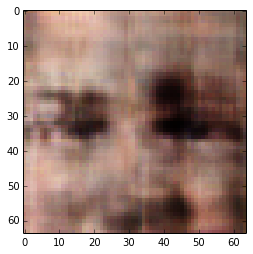


 1.0185
[torch.FloatTensor of size 1]


 1.0608
[torch.FloatTensor of size 1]



AssertionError: 

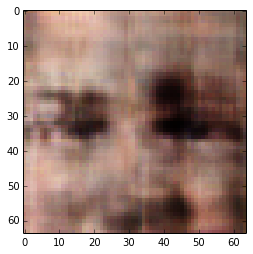

In [91]:
num_epochs = 100
for epoch in range(num_epochs):
    for i, (data, _) in enumerate(dataloader):

        discriminator.zero_grad()
        fake_data = generator(Variable(torch.randn(16, 100))).detach()
        real_data = data

        fake_D = discriminator(fake_data)
        real_D = discriminator(Variable(real_data))

        negetive_loss = criterion(fake_D, Variable(torch.zeros(16)))
        positive_loss = criterion(real_D, Variable(torch.ones(16)))

        negetive_loss.backward()
        positive_loss.backward()

        op_d.step()


        generator.zero_grad()
        gen_image = generator(Variable(torch.randn(16, 100)))
        fake_D_for_g = discriminator(gen_image)
        gen_loss = criterion(fake_D_for_g, Variable(torch.ones(16)))

        gen_loss.backward()

        op_g.step()

        if i % 10 == 0:

            show(gen_image.data[0])
            print positive_loss.data + negetive_loss.data
            print gen_loss.data